## Damped Harmonic Oscillator

- Subject: Physics-informed Neural Networks
- Reference:
  - https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/
  - https://github.com/benmoseley/harmonic-oscillator-pinn-workshop/blob/main/PINN_intro_workshop.ipynb
- created: 2024.11.16

### Problem

Solve an inital value problem:

$$m\frac{d^2u}{dt^2} + \mu\frac{du}{dt} + k u =0,\quad u(0)=1,\quad \frac{du}{dt}(0) = 0,\quad t\in[0, 1]$$

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loss Functions and Data

In [3]:
## Equation parameters:
d, w0 = 2, 20       ## reference value w0 = 20
mu, k = 2*d, w0**2

def u_exact(t, d=d, w0=w0):
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    return 2*A*np.cos(phi + w*t)*np.exp(-d*t)

In [4]:
def gradient(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                create_graph=True, retain_graph=True)[0]

def to_tensor(x):
    return torch.tensor(x).float().view(-1, 1).to(device)

In [5]:
from pinn import gradient

def residual_loss(model, t):
    t.requires_grad = True
    u = model(t)
    u_t = gradient(u, t)
    u_tt = gradient(u_t, t)
    residual = u_tt + mu*u_t + k*u
    return torch.mean(residual**2)

def ic_du_loss(model, t):
    t.requires_grad = True
    u = model(t)
    u_t = gradient(u, t)
    return torch.mean((u_t[0] - 0)**2)

## Collocation points (Domain): residual loss
t_np = np.linspace(0, 1, 101)
t = to_tensor(t_np)

## Initial points: initial condition loss
t0 = to_tensor(0)
u0 = to_tensor(1)

### Modeling and Training

In [8]:
from pinn import MLP, Trainer

Epoch[10000/10000] (lr: 6.30e-04) TOTAL: 1.00e+00, RESIDUAL: 7.90e-05, IC_DU: 4.97e-07, IC_U: 1.00e+00: 100%|####################################################| 10000/10000 [01:31<00:00, 109.69it/s]


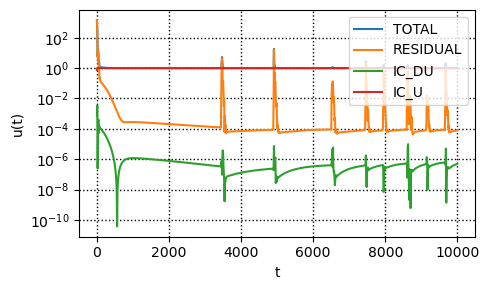

In [9]:
## Model
model = MLP(layer_sizes=[1, 50, 50, 50, 1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.95)

## Training
loss_functions = {}
loss_functions["residual"] = residual_loss
loss_functions["ic_du"] = ic_du_loss

targets = {}
targets["ic_u"] = t0, u0

n_epochs = 10000
ivp = Trainer(model, optimizer, loss_functions, targets)
history = ivp.fit(t, n_epochs, scheduler=scheduler, update_step=20)
ivp.show_history()

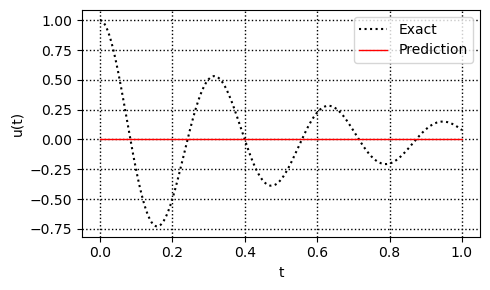

In [10]:
## Evaluation
t_test_np = np.linspace(0, 1, 1001)
t_test = torch.tensor(t_test_np).float().view(-1, 1).to(device)

with torch.no_grad():
    u_pred = model(t_test)
    u_pred_np = u_pred.cpu().detach().numpy().flatten()

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(t_test_np, u_exact(t_test_np), 'k:', label="Exact")
ax.plot(t_test_np, u_pred_np, 'r', lw=1, label="Prediction")
ax.legend(loc="upper right")
ax.grid(color='k', ls=':', lw=1)
ax.set_xlabel("t")
ax.set_ylabel("u(t)")
fig.tight_layout()
plt.show()

### Modeling and Training with Loss Weights

Epoch[10000/10000] (lr: 6.30e-04) TOTAL: 2.45e-04, RESIDUAL: 2.44e-04, IC_DU: 5.47e-11, IC_U: 4.70e-07: 100%|#####################################################| 10000/10000 [02:04<00:00, 80.35it/s]


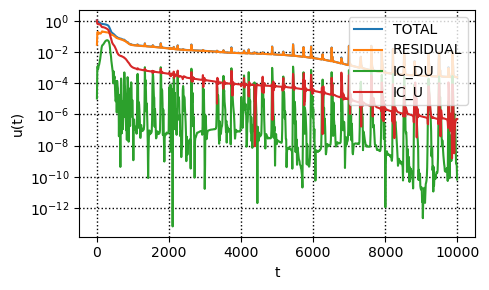

In [11]:
## Model
model = MLP(layer_sizes=[1, 50, 50, 50, 1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.95)

## Training
loss_functions = {}
loss_functions["residual"] = residual_loss
loss_functions["ic_du"] = ic_du_loss

targets = {}
targets["ic_u"] = t0, u0

n_epochs = 10000
ivp = Trainer(model, optimizer, loss_functions, targets)
ivp.loss_weights["residual"] = 1e-4
ivp.loss_weights["ic_du"] = 1e-2
history = ivp.fit(t, n_epochs, scheduler=scheduler, update_step=20)
ivp.show_history()

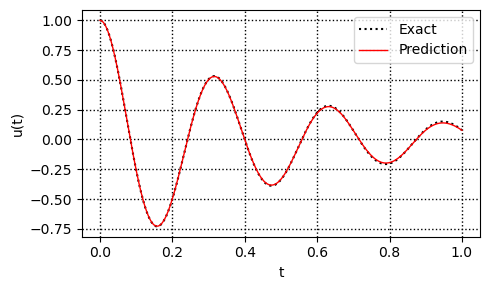

In [12]:
## Evaluation
t_test_np = np.linspace(0, 1, 1001)
t_test = torch.tensor(t_test_np).float().view(-1, 1).to(device)

with torch.no_grad():
    u_pred = model(t_test)
    u_pred_np = u_pred.cpu().detach().numpy().flatten()

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(t_test_np, u_exact(t_test_np), 'k:', label="Exact")
ax.plot(t_test_np, u_pred_np, 'r', lw=1, label="Prediction")
ax.legend(loc="upper right")
ax.grid(color='k', ls=':', lw=1)
ax.set_xlabel("t")
ax.set_ylabel("u(t)")
fig.tight_layout()
plt.show()

### Modeling and Training with Loss Weights

Epoch[10000/10000] (lr: 6.30e-04) TOTAL: 3.41e-04, RESIDUAL: 2.65e-04, IC_DU: 3.73e-08, IC_U: 1.76e-09, DATA: 7.56e-05: 100%|#####################################| 10000/10000 [02:21<00:00, 70.63it/s]


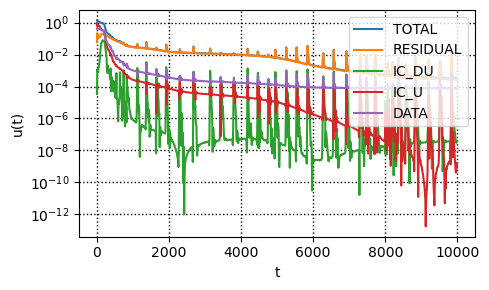

In [13]:
n_data = 50
t_data_np = np.linspace(0, 0.2, n_data) + np.random.randn(n_data)*0.01
u_data_np = u_exact(t_data_np) + np.random.randn(n_data)*0.01
t_data = torch.tensor(t_data_np).float().view(-1, 1).to(device)
u_data = torch.tensor(u_data_np).float().view(-1, 1).to(device)

## Model
model = MLP(layer_sizes=[1, 50, 50, 50, 1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.95)

## Training
loss_functions = {}
loss_functions["residual"] = residual_loss

loss_functions["ic_du"] = ic_du_loss

targets = {}
targets["ic_u"] = t0, u0
targets["data"] = t_data, u_data

n_epochs = 10000
ivp = Trainer(model, optimizer, loss_functions, targets)
ivp.loss_weights["residual"] = 1e-4
ivp.loss_weights["ic_du"] = 1e-2
history = ivp.fit(t, n_epochs, scheduler=scheduler, update_step=20)
ivp.show_history()

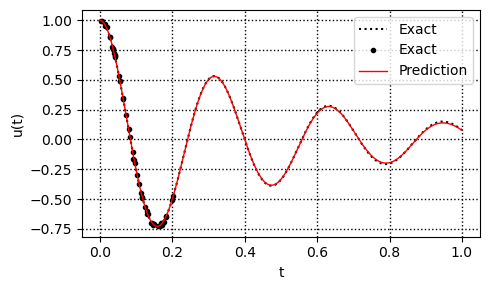

In [14]:
## Evaluation
t_test_np = np.linspace(0, 1, 1001)
t_test = torch.tensor(t_test_np).float().view(-1, 1).to(device)

with torch.no_grad():
    u_pred = model(t_test)
    u_pred_np = u_pred.cpu().detach().numpy().flatten()

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(t_test_np, u_exact(t_test_np), 'k:', label="Exact")
ax.plot(t_data_np, u_data_np, 'ko', ms=3, label="Exact")
ax.plot(t_test_np, u_pred_np, 'r', lw=1, label="Prediction")
ax.legend(loc="upper right")
ax.grid(color='k', ls=':', lw=1)
ax.set_xlabel("t")
ax.set_ylabel("u(t)")
fig.tight_layout()
plt.show()